<a href="https://colab.research.google.com/github/cohmathonc/BIOSCI544/blob/master/BIOSCI544_CancerTreatmentModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Treatment Models

An important application of cancer growth models is for treatment optimization.
Here we will review and implement some of the treatment models that lead to the development of important treatment paradigms. 

Some of the content of this notebook is based on [[1]](#Benzekry_2015) which provides an overview of the historic development of mathematical models for chemotherapy.

## Log-Kill Hypothesis

Skipper, Schable and Wilcox introduced the first theoretical concepts for the optimal design of chemotherapy schedules in the 1960.
They observed that L1210 leukemic cells in mice grow *exponentially*,  until a lethal tumor volume of about $10^9$ cells [[2]](#SKIPPER_1964).
Exponential growth implies a constant doubling time, or more generally, a constant fractional increase, regardless of tumor size. 

The Skipper-Schabel-Wilcox model postulates that **"a given dose of a given drug will kill approximately the same fraction, not the same number, of widely different-sized tumor cell populations -- so long as they are similarly exposed and both the growth fraction and the proportion of drug-resistant phenotypes are the same."**

This model resulted in development of the **log kill hypothesis** which  states that the same fraction of tumor cells is killed by a given dose of chemotherapy kills, regardless of the size of the tumor at the time of treatment. 

Reduction of the cell population by a constant fraction, corresponds to a reduction by a constant amount on a logarithmic scale.
For instance, reducing a population of $N=10^4$ cells to $N'=10^3$ cells corresponds to a 90% decrease in cell number, or a decrease by 1 on a logarithmic scale:

\begin{align}
\frac{N}{N'}&=10  &\rightarrow & &\text{log kill}&=\log_{10}\frac{N}{N'}=1 \\
&&&&\frac{N-N'}{N} &=1-\frac{1}{10}=90\%
\end{align}
This is called a "one log-kill" effect.

### Model

Consider the following model:

$$\frac{d N}{d t}= \rho N - \kappa\, C(t)\, N $$

where $N$ is the *number of tumor cells*, $\rho$ is the *exponential growth rate*, $C(t)$ the rate by which a dose $D$ of some therapeutic agent is acting on the the tumor and $\kappa$ the *sensitivity* of tumor cells to this agent. 

Here, we assume that the effect of the agent is immediate and not affected by metabolism.
In this case, $C(t)$ is identical to the instantaneous dose rate $I(t)$ at which the agent enters the body:
$$C(t)=I(t)=\frac{d D}{d t}$$

Units:
\begin{align}
[N] &= 1  & [\rho] &= \frac{1}{T}  & [C]&=\frac{[D]}{T} & [\kappa] &= \frac{1}{[D]} 
\end{align}


If we assume that $C(t)$ is non-zero only in some time interval $t\in [t_{\text{start}}, t_{\text{end}}]$ during which treatment is given then we have a model that looks like this:

$$\frac{d N}{d t}= 
\begin{cases}
\rho N & \text{for } t < t_{\text{start}}, \, t >t_\text{end}\\
\rho N - \kappa\, C(t)\, N  & \text{for } t_{\text{start}} \leq t \leq t_\text{end}\\
\end{cases}
$$

Assume that total dose $D$ can be delivered "*instantaneously*" relative to the relevant time scale and $t_{\text{start}} \leq t_\text{treat} \leq t_{\text{end}}$:


$$\text{log kill} = \log_{10}\frac{N(t_\text{start})}{N(t_\text{end})}= \frac{\kappa\, D - \rho\,(t_{\text{end}}-t_{\text{start}})}{\log_e(10)}\, ,$$

which means that the killing ratio *log kill* depends on the duration of the treatment (regrowth!) and the total dose given during treatment, but not on the time at which treatment is given.



Let's assume that the dose $D$ of the drug reaches tumor cells at constant rate throughout the duration of treatment $T$: 

$$C(t) = C = \frac{D}{T}\qquad \text{for  }\, t_{\text{start}} \leq t \leq t_\text{end}$$



### Implementation

In [0]:
import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import solve_ivp, simps

font = {'font.family' : 'normal',
        'font.weight' : 'normal',
        'font.size'   : 20}
plt.rcParams.update(font)

In [0]:
def model_log_kill(t, y, r=0.1, k=1, C=0):
    """
    y[0] corresponds to tumor cell number N(t)
    y_p[0] corresponds to change in tumor cell number dN/dt
    r = exponential growth factor
    C = current dose rate experienced by tumor
    k = killing efficiency
    """
    y_p = np.zeros(y.shape)
    y_p[0] = r * y[0] -  k * y[0] * C  
    return y_p

In [0]:
def plot_dose_tumor(t, y, administered_dose_rate=None, received_dose_rate=None, 
                    prolif_fraction=None, show_hlines=True, labels=[]):
    subplot_cnt = 0
    has_dose_rate = isinstance(administered_dose_rate, np.ndarray) or isinstance(received_dose_rate, np.ndarray)
    has_prolif_fraction = isinstance(prolif_fraction, np.ndarray)
    if has_dose_rate and has_prolif_fraction and y.ndim==1:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[1, 3, 1]})
        N = y
    elif has_dose_rate and y.ndim==1:
        fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[2, 3]})
        N = y
    elif has_dose_rate and has_prolif_fraction and y.ndim>1:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[1, 3, 1]})
        N = y[0,:]
        N2= y[1,:]
    elif has_dose_rate and y.ndim>1:
        fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[2, 3]})
        N = y[0,:]
        N2= y[1,:]

    # plot dose
    if has_dose_rate:
        if isinstance(administered_dose_rate, np.ndarray):
            axes[0].plot(t, administered_dose_rate, label='administered dose I(t)')
        if isinstance(received_dose_rate, np.ndarray):
            axes[0].plot(t, received_dose_rate, label='dose acting on tumor C(t)')
        axes[0].set_ylabel('dose rate')
        axes[0].legend()
        axes[0].grid()
        axes[0].axhline(y=0, c='k', linestyle='--')  
    
    # plot tumor cell population
    if y.ndim==1:
        axes[1].plot(t, N)
    else:
        for dim in range(y.shape[0]):
            if len(labels)==y.shape[0]:
                axes[1].plot(t, y[dim, :], label=labels[dim])
            else:
                axes[1].plot(t, y[dim, :])
    axes[1].set_ylabel('tumor cells $N(t)$')
    axes[1].set_yscale('log')
    N_min = np.min(N)
    N_max = np.max(N)
    axes[1].set_ylim(0.1, 5*N_max )
    axes[1].set_yticks(np.logspace(0, int(np.log10(N_max)), num=(int(np.log10(N_max))+1)))
    axes[1].axhline(y=1, c='k', linestyle='--')
    axes[1].legend()
    axes[1].grid()
    
    if has_prolif_fraction:
        axes[2].plot(t, prolif_fraction)
        axes[2].set_ylabel('Gompertz Growth $G$')
        axes[2].set_xlabel('time [days]')
        axes[2].grid()
    else:
        axes[1].set_xlabel('time [days]')
        
    if isinstance(dose_rate, np.ndarray) and show_hlines:
        for i, d in enumerate(dose_rate):
            if d>0:
                for ax in axes:
                    ax.axvline(x=t[i], color='r', linestyle=':')
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.05)
    plt.show()
    return axes 

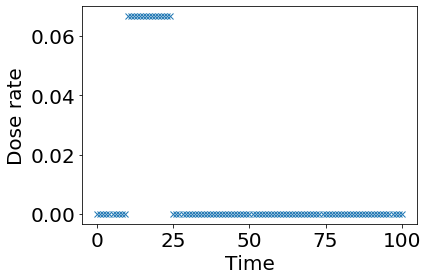

In [139]:
# this function and its parameters are specific to the type of dosing schedule chosen
def dose_administration_rate(t, t_start, T, D):
    """
    t: discretization of simulation time period
    t_start: start of treatment
    T: duration of treatment
    D: total dose pere treatment (given at constant rate D/T)
    """
    delta_t = t[1]-t[0]
    t_end = t_start+T
    dose_rate = np.zeros(t.shape)
    for i, ti in enumerate(t):
        if (ti>=t_start) and (ti<t_end): 
            dose_rate[i] = D
    dose_rate = dose_rate/len(dose_rate[dose_rate>0])/delta_t
    return dose_rate

# discretization of simulation time period
sim_time = 100
delta_t  = 1
t = np.arange(0, sim_time+delta_t, delta_t)

# treatment schedule
t_start  = 10.0
T = 5
t_end    = t_start + T
dose_rate = dose_administration_rate(t, t_start, t_end, 1)

plt.plot(t, dose_rate, 'x')
plt.xlabel('Time'), plt.ylabel('Dose rate')
plt.show()

No handles with labels found to put in legend.


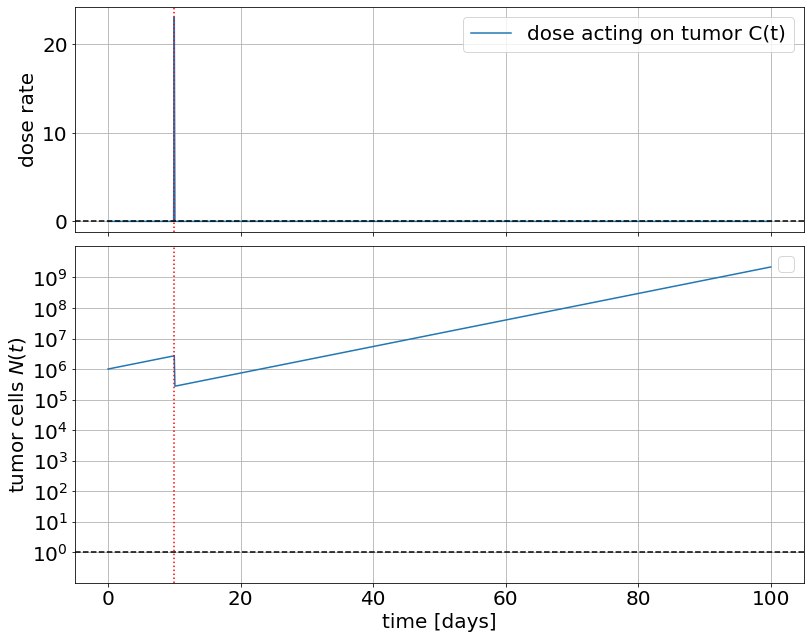

log kill between time '10.00' and '10.10': 0.990988


In [140]:
# Solve model

# time period
sim_time = 100
delta_t  = 0.1
t = np.arange(0, sim_time+delta_t, delta_t)

# treatment schedule
t_start  = 10.0
T = 0.1

total_dose = 1 * np.log(10)
dose_rate = dose_administration_rate(t, t_start, T, total_dose)

# other model parameters
log_growth = 0.1
kill_eff = 1
initial_tumor_cell_population = 1E6

# solution
y = np.ones(t.shape[0])*np.nan                       # initialize solution array 
y[0] = np.array(initial_tumor_cell_population)       # initial values
for i in range(len(t)-1):
    sol = solve_ivp(fun=lambda t, y: model_log_kill(t, y, r=log_growth, k=kill_eff, C=dose_rate[i]),
                    t_span=[t[i],t[i+1]], y0=[y[i]])
    y[i+1] = sol.y[-1][-1]               

# plot results
plot_dose_tumor(t, y, received_dose_rate=dose_rate)

# compute log kill
t_end = t_start + T
i_start = (np.abs(t-t_start)).argmin() 
i_end = (np.abs(t-t_end)).argmin()
log_kill = np.log10(y[i_start]/y[i_end+1])
print("log kill between time '%.2f' and '%.2f': %f"%(t_start, t_end, log_kill))



Assume that the entire dose $D$ is delivered in a single time step.
If the simulation time step is large compared to the time scale of tumor regrowth, we can assume that 

$$\text{log kill} = \log_{10}\frac{N(t_\text{start})}{N(t_\text{stop})} \approx \frac{\kappa\, D}{\log_e(10)} $$
and thus
$$\kappa\, D \approx \text{log kill} \cdot \log_e(10)$$

So to achieve *1 log kill*, $\kappa\, D = 1 \cdot \log_e(10)$

### Repeated Treatment Administration

Often, therapy is administered in cycles with a certain repetition period.

In [0]:
def dose_administration_rate_cycles(t, t_start, T, n_cycles, cycle_period, D_cycle):
    delta_t = t[1]-t[0]
    steps_per_cycle = int(cycle_period/delta_t)
    dose_rate = np.zeros(t.shape)
    # find start time of first cycle
    start_time_index = (np.abs(t-t_start)).argmin() 
    # compute dose rate for each cycle
    for i_cycle in range(n_cycles):
        i_start = start_time_index+i_cycle*steps_per_cycle
        i_end   = start_time_index+(i_cycle+1)*steps_per_cycle
        for i in range(i_start, i_end):
            if (t[i]>=t[i_start]) and (t[i]<t[i_start]+T):
                dose_rate[i] = D_cycle
        # normalize total dose given in cycle to D_cycle
        dose_rate_cycle = dose_rate[i_start:i_end]
        #print(len(dose_rate_cycle[dose_rate_cycle>0]))
        dose_rate_cycle = dose_rate_cycle/len(dose_rate_cycle[dose_rate_cycle>0])/delta_t
        dose_rate[i_start:i_end] = dose_rate_cycle
    return dose_rate

accumulative dose: 15.000000


No handles with labels found to put in legend.


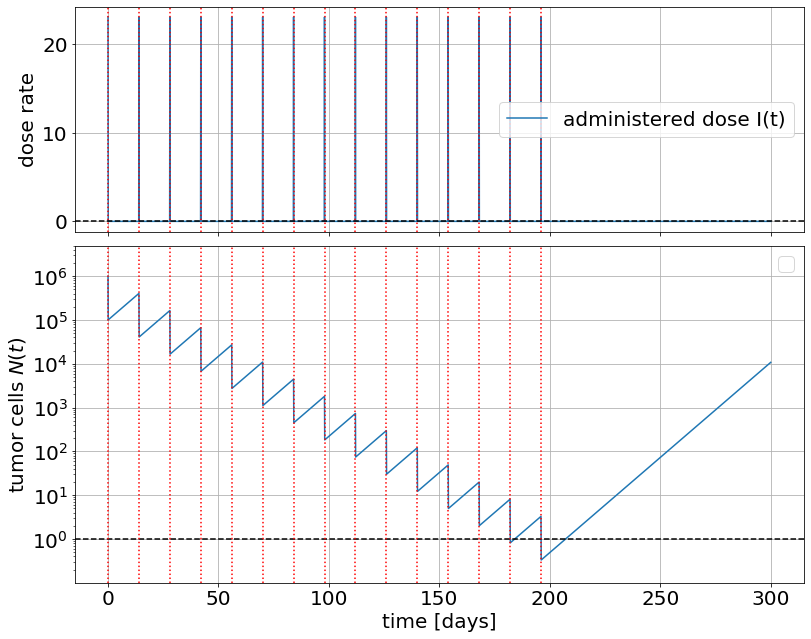

In [142]:
# Solve model

# time period
sim_time = 300
delta_t  = 0.1
t = np.arange(0, sim_time+delta_t, delta_t)

# treatment schedule
t_start  = 0.0
T = 0.1

n_cycles = 15
cycle_period = 14
total_dose = 1 * np.log(10)
# n_cycles = 30
# cycle_period = 7
# total_dose = 0.5 * np.log(10)

print("accumulative dose: %f"%(n_cycles*total_dose/np.log(10)))

dose_rate = dose_administration_rate_cycles(t, t_start, T, n_cycles, cycle_period, total_dose)

# other model parameters
log_growth = 0.1
kill_eff = 1
initial_tumor_cell_population = 1E6

# solution
y = np.ones(t.shape[0])*np.nan                       # initialize solution array 
y[0] = np.array(initial_tumor_cell_population)       # initial values
for i in range(len(t)-1):
    sol = solve_ivp(fun=lambda t, y: model_log_kill(t, y, r=log_growth, k=kill_eff, C=dose_rate[i]),
                    t_span=[t[i],t[i+1]], y0=[y[i]])
    y[i+1] = sol.y[-1][-1]               

# plot results
plot_dose_tumor(t, y, administered_dose_rate=dose_rate, received_dose_rate=None)
plt.show()

Tumor eradication and *cure* is assumed when $N(t)<1$ at some time point $t$.

**Note:**

ODE-based models describe average quantities. 
When the magnitudes of those quantities assume values that correspond to (few) single objects, e.g. single cells, or fractions, this description may become unsuitable.

First, fractions of single objects may not be meaningful. For example, the ode model here predicts recurrence from tumor cell numbers $N<<1$.
Second, stochastic effects gain importance and may critically influence the systems' behavior.

Indeed, it was demonstrated [[3]](#Skipper_1965) (for Leukemia)  that a large-dose / short time shedule was superior to a chronic low-dose schedule with similar or larger dose.

However, the experimental system was limited to a specific leukemic cell line, and when applied to other (solid) tumors, the log-kill hypothesis did not lead to the expected results.
Also, this model assumes the cancer cell population to be homogeneously sensitive to the drug.

## Norton-Simon Hypothesis

Studies of tumor kinetics in the 1960 led to the realization that the growth rate of solid tumors was not constant but rather decreased with tumor volume.
It was shown that the growth curve patterns could be well described by several growth models, the most famous one of those being the Gompertz model; [[4]](#Benzekry_2014) provides a recent overview of different models and their predictive properties for experimental data.

Norton and Simon [[5]](#Norton_1977) revisited the log-kill hypothesis in the 1970 in order to extend it to growing tumors with non-constant specific growth rate.
As chemotherapy is mostly based on anti-mitotic agents, they suggest that only actively proliferating cells should be affected by treatment.

### Model

Recall the Gompertz Model:
    
\begin{align}
      \frac{dN}{dt} &=G(t)N(t) \tag{1}\\
      \frac{dG}{dt} &=-\gamma\, G(t) 
\end{align}

where the population $N(t)$ grows or shrinks over time with time-dependent growth factor $G(t)$, and the growth factor $G(t)$ decays exponentially over time with constant rate $\gamma$. 

We implement Norton and Simon's hypothesis by extending equation (1) of this model by a treatment term ($-\kappa\, C(t)$, as before) that only affects the proliferative fraction $G(t)$ of the tumor.

$$\frac{dN}{dt} =G(t)\, N(t)\, (1-\kappa\, C(t)) $$

Instead of modeling the decrease of the proliferative fraction $G$ over time, here we are interested in the relation between proliferative fraction and tumor population so that the treatment-Gompertz model has the form:

$$\frac{dN}{dt} =\gamma\ln\left(\frac{K}{N}\right)\, N(t)\, (1-\kappa\, C(t)) $$

### Implementation

In [0]:
def model_norton_simon(t, y, r=1, K=1, k=1, C=0):
    """
    y[0] corresponds to tumor cell number N(t)
    y_p[0] corresponds to change in tumor cell number dN/dt
    r = exponential growth factor
    C = current dose rate experienced by tumor
    k = killing efficiency
    """
    y_p = np.zeros(y.shape)
    y_p[0] = r*np.log(K/y[0])* y[0] * (1 -  k * C)  
    return y_p

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


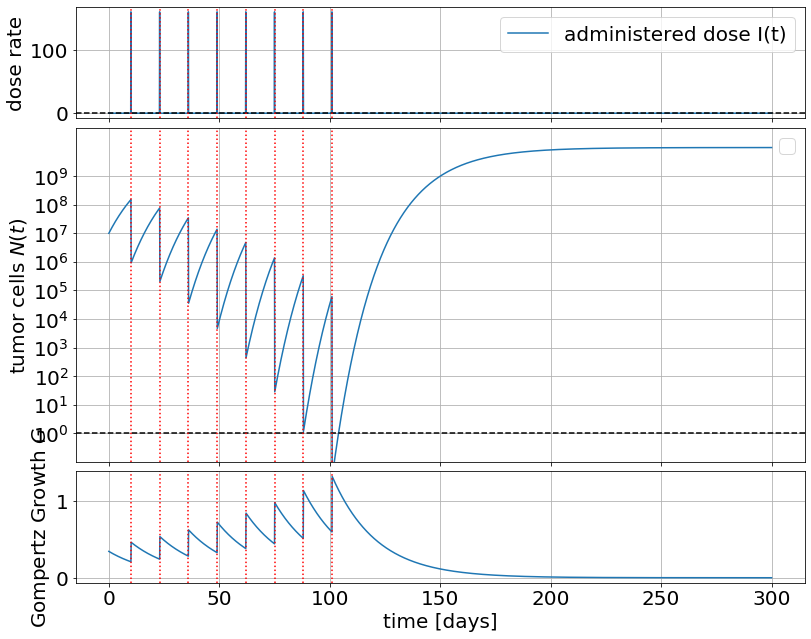

In [144]:
# Solve model

# time period
sim_time = 300
delta_t  = 0.1
t = np.arange(0, sim_time+delta_t, delta_t)

# treatment schedule
t_start  = 10.0
T = 0.1

n_cycles = 8
cycle_period = 13
total_dose = 16

dose_rate = dose_administration_rate_cycles(t, t_start, T, n_cycles, cycle_period, total_dose)

# other model parameters
gomp_growth = 0.05

kill_eff = 1
initial_tumor_cell_population = 1E7
carrying_cap = 1E10

# solution
y = np.ones(t.shape[0])*np.nan                       # initialize solution array 
y[0] = np.array(initial_tumor_cell_population)       # initial values
for i in range(len(t)-1):
    sol = solve_ivp(fun=lambda t, y: model_norton_simon(t, y, r=gomp_growth, K=carrying_cap, k=kill_eff, C=dose_rate[i]),
                    t_span=[t[i],t[i+1]], y0=[y[i]])
    y[i+1] = sol.y[-1][-1]               

    
# plot results
prolif_fraction = gomp_growth*np.log(carrying_cap/y)
axes = plot_dose_tumor(t, y, administered_dose_rate=dose_rate, received_dose_rate=None, prolif_fraction=prolif_fraction)


# add different dosing schedule
# cycle_period = 15
# dose_rate = dose_administration_rate_cycles(t, t_start, T, n_cycles, cycle_period, total_dose)
# # solution
# y2 = np.ones(t.shape[0])*np.nan                       # initialize solution array 
# y2[0] = np.array(initial_tumor_cell_population)       # initial values
# for i in range(len(t)-1):
#     sol = solve_ivp(fun=lambda t, y: model_norton_simon(t, y, r=gomp_growth, K=carrying_cap, k=kill_eff, C=dose_rate[i]),
#                     t_span=[t[i],t[i+1]], y0=[y2[i]])
#     y2[i+1] = sol.y[-1][-1]               

# axes[1].plot(t, y2, label='15 day cycle')


The Norton-Simon Hypothesis predicts superiority of densified dosing regimens:
Less intercycle time implies less regrowth, smaller size at beginning of next cycle implies larger proliferating fraction and thus larger fraction killed by the drug.
This has been confirmed in clinical trials that reduced inter-cycle time from 21 days to 14 days and showed benefit of the applying the denser regimen [[6]](#Held_2006).

Another result from this model is that multidrug combination therapies are most effective when drugs are administered sequentially rather than alternating, so that the treatment schedule for each of the drugs is 'densified'. This prediction was confirmed in clinical trials in e.g. breast cancer [[7]](#Citron_2003).

The Norton-Simon model implies that larger absolute kill of cancer cells resulting from early therapy might be counter-balanced by faster regrowth due to the higher growth rates of those smaller tumors.
This may explain observations that adjuvant chemotherapy of breast cancer has less impact on overall survival (a function of eventual tumor body burden) than on disease-free survival (time to relapse), see this [figure](https://www.ncbi.nlm.nih.gov/books/NBK20771/figure/A8245/?report=objectonly) in [[8]](#Gilewski).

## Tumor Heterogeneity

Both, the log-kill and Norton-Simon hypotheses assume the population of cancer cells to be homogeneous, with equal sensitivity to the treatment drug.
We now consider the problem of dosing for heterogeneous tumors, consisting of subpopulations of cancer cells with distinctive sensitivities to a given drug.
The following model is based on [[8]](#Hahnfeldt_2003).

\begin{align}
\frac{dN_1}{dt} & = \left(\rho_1 - \gamma_1 - \alpha\, C(t)\right)\, N_1(t) + \gamma_2\, N_2(t) \\
\frac{dN_2}{dt} & = \left(\rho_2 - \gamma_2 - \beta\, C(t)\right)\, N_2(t) + \gamma_1\, N_1(t) \\
\end{align}

Cells of subpopulation $N_1$ and $N_2$ have net proliferations $\rho_1$, $\rho_2$ and experience exposure to the treatment drug $C(t)$ different with different sensitivities $\alpha$ and $\beta$.
Cells from one subpopulation can move to the other subpopulation with transition rates $\gamma_1$ and $\gamma_2$.
This transition may for example correspond to cells moving from a non-mitotic compartment to a mitotic one and vice versa.

Due to different sensitivities, exposure to treatment will alter the relative proportion of cells in each of the subpopulations from their equilibrium proportions.
Transition rates between these subpopulations capture the tendency of these subpopulations to return to their equilibrium proportions once the toxic insult ceases.

### 'Metronomic' and irregular dosing schedules

In [0]:
def model_heterogeneity(t, y, r1=1, r2=1, g1=0.5, g2=0.5, a=0.1, b=0.2, C=0):
    """
    y[0] corresponds to tumor cell number N1(t)
    y[1] corresponds to tumor cell number N2(t)
    y_p[0] corresponds to change in tumor cell number dN1/dt
    y_p[1] corresponds to change in tumor cell number dN2/dt
    r1, r2 = exponential growth factors
    g1, g2 = conversion rates
    a, b = drug sensitivities
    """
    y_p = np.zeros(y.shape)
    y_p[0] = (r1 - g1 - a*C) * y[0] + g2 * y[1]
    y_p[1] = (r2 - g2 - b*C) * y[1] + g1 * y[0]
    return y_p

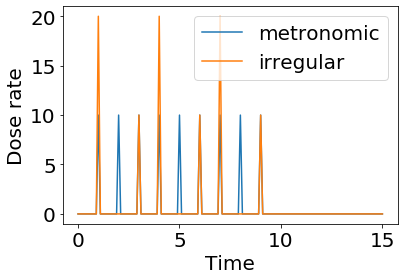

In [146]:
# time period
sim_time = 15
delta_t  = 0.1
t = np.arange(0, sim_time+delta_t, delta_t)

# treatment schedule
t_start  = 1.0
T = 0.1

dose_rate_metronomic = dose_administration_rate_cycles(t, t_start=1, T=0.1, n_cycles=9, 
                                                  cycle_period=1, D_cycle=1)
dose_rate_irreg_high = dose_administration_rate_cycles(t, t_start=1, T=0.1, n_cycles=3, 
                                                  cycle_period=3, D_cycle=2)
dose_rate_irreg_low  = dose_administration_rate_cycles(t, t_start=3, T=0.1, n_cycles=3, 
                                                  cycle_period=3, D_cycle=1)
dose_rate_irreg = dose_rate_irreg_low + dose_rate_irreg_high

ax1=plt.plot(t, dose_rate_metronomic,label='metronomic')
ax2=plt.plot(t, dose_rate_irreg,label='irregular')
#plt.plot(t, dose_rate_irreg_high)
#plt.plot(t, dose_rate_irreg_low)
plt.legend()
plt.xlabel('Time'),plt.ylabel('Dose rate')
plt.show()

## Solving the model

In [0]:
# define solver for reuse
def solve(t, N0, r1, r2, g1, g2, a, b, dose_rate):
    y = np.ones((2,t.shape[0]))*np.nan                     # initialize solution array 
    y[:,0] = np.array([N0,N0])                             # initial values
    for i in range(len(t)-1):
        sol = solve_ivp(fun=lambda t, y: model_heterogeneity(t, y, r1=r1, r2=r2, g1=g1, g2=g2, 
                                                             a=a, b=b, C=dose_rate[i]),
                        t_span=[t[i],t[i+1]], y0=y[:,i])
        y[:,i+1] = sol.y[:,-1]               

    y_sum = np.sum(y, axis=0)
    y_all = np.vstack([y,y_sum])
    return y_all

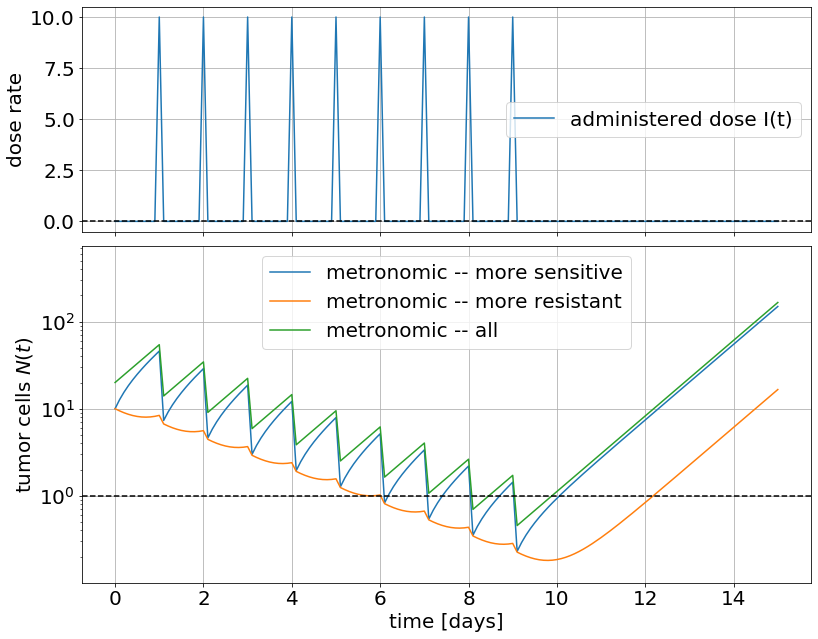

In [148]:
r1 = r2 = 1.0
a = 1.0
b = 0.1
# slow resensitization
g1 = 0.2
g2 = 1.8

dose_factor = 2
N0 = 10

# solution metronomic
y_metr_all = solve(t, N0, r1, r2, g1, g2, a, b, dose_rate_metronomic*dose_factor)

labels = ['more sensitive', 'more resistant', 'all']

axes = plot_dose_tumor(t, y_metr_all, administered_dose_rate=dose_rate_metronomic, received_dose_rate=None, 
                       labels=['metronomic -- '+label for label in labels], show_hlines=False)

### Response to these dosing schedules

- Two subpopulations, with high and low sensitivity, respectively.
- Treated by 'irregular' and metronomic schedule

'Irregular' schedule with higher dose upfront is competitive early on, but not in the long term.

In [0]:
# params from fig 5
r1 = r2 = 1.0
a = 1.0
b = 0.1
g1 = 0.2
g2 = 1.8

dose_factor = 4
N0 = 10

# solution metronomic
y_metr_all = solve(t, N0, r1, r2, g1, g2, a, b, dose_rate_metronomic*dose_factor)
  
# solution irregular
y_irr_all = solve(t, N0, r1, r2, g1, g2, a, b, dose_rate_irreg*dose_factor)

labels = ['more sensitive', 'more resistant', 'all']
# axes = plot_dose_tumor(t, y_metr_all, administered_dose_rate=dose_rate_metronomic, received_dose_rate=None, 
#                        labels=['metronomic -- '+label for label in labels], show_hlines=False)

# for i, label in enumerate(labels):
#     axes[1].plot(t, y_irr_all[i,:], label='irregular -- '+ label, line_style = '--')
# axes[1].legend()

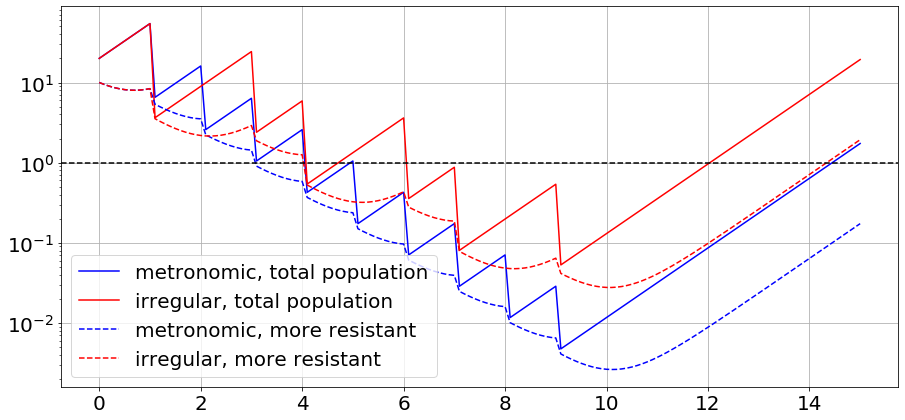

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
# metronomic -- blue
# irregular -- red
# total population -- solid
ax.plot(t, y_metr_all[2,:], color='b', linestyle='-', label='metronomic, total population')
ax.plot(t, y_irr_all[2,:], color='r', linestyle='-', label='irregular, total population')
# more resistant -- dashed
ax.plot(t, y_metr_all[1,:], color='b', linestyle='--', label='metronomic, more resistant')
ax.plot(t, y_irr_all[1,:], color='r', linestyle='--', label='irregular, more resistant')
ax.axhline(y=1, c='k', linestyle='--')
ax.set_yscale('log')
ax.grid()
ax.legend()

### Effect of resensitization rate on treatment effect

- Two subpopulations, with high and low sensitivity, respectively
- Treated by 'irregular' and metronomic schedule
- two scenarios: slow vs quick resensitization

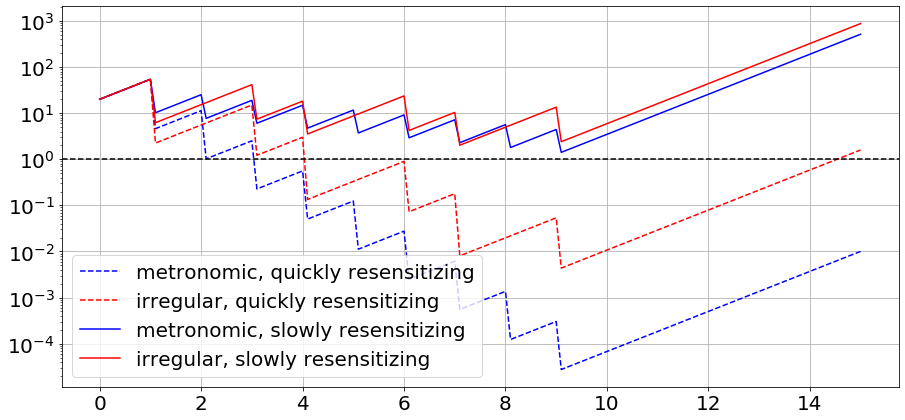

In [164]:
# params from fig 6
r1 = r2 = 1.0
a = 1.0
b = 0.1

dose_factor = 4
N0 = 10

#== slow resensitization
g1 = 0.1
g2 = 0.9
y_metr_slow_all = solve(t, N0, r1, r2, g1, g2, a, b, dose_rate_metronomic*dose_factor)
y_irr_slow_all = solve(t, N0, r1, r2, g1, g2, a, b, dose_rate_irreg*dose_factor)

#== quick resensitization
g1 = 0.4
g2 = 3.6
y_metr_quick_all = solve(t, N0, r1, r2, g1, g2, a, b, dose_rate_metronomic*dose_factor)
y_irr_quick_all = solve(t, N0, r1, r2, g1, g2, a, b, dose_rate_irreg*dose_factor)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
# metronomic -- blue
# irregular -- red
# quickly resentizing -- dashed
ax.plot(t, y_metr_quick_all[2,:], color='b', linestyle='--', label='metronomic, quickly resensitizing')
ax.plot(t, y_irr_quick_all[2,:], color='r', linestyle='--', label='irregular, quickly resensitizing')
# slowly resensitizing -- solid
ax.plot(t, y_metr_slow_all[2,:], color='b', linestyle='-', label='metronomic, slowly resensitizing')
ax.plot(t, y_irr_slow_all[2,:], color='r', linestyle='-', label='irregular, slowly resensitizing')
ax.axhline(y=1, c='k', linestyle='--')
ax.set_yscale('log')
ax.grid()
ax.legend()
plt.show()

Differential response between irregular (red) and metronomic (blue) is small in the slowly resensitizing scenario (solid) but large in the quickly resensitizing scenario (dashed).

The slow resensitizing case may be representative of tumor cell populations, whereas the quickly resensitizing case may be more representative of endothelial cells which are also affected by chemotherapy.

This differential response of quickly resensitizing populations under irregular vs metronomic treatment schedules has been proposed as explanation for the observed increased therapeutic gain under metronomic dosing:
Metronomic dosing may potentiate the anti-angiogenic properties of chemotherapeutic drugs.

# References

<a id='Benzekry_2015'>[1]</a>
Benzekry, S., Pasquier, E., Barbolosi, D., Lacarelle, B., Barlési, F., André, N., Ciccolini, J., 2015. Metronomic reloaded: Theoretical models bringing chemotherapy into the era of precision medicine. Semin. Cancer Biol. 35, 53–61. https://doi.org/10.1016/j.semcancer.2015.09.002

<a id='SKIPPER_1964'>[2]</a>
SKIPPER, H.E., SCHABEL Jr., F.M., WILCOX, W.S., 1964. EXPERIMENTAL EVALUATION OF POTENTIAL ANTICANCER AGENTS. XIII. ON THE. Cancer Chemother. Rep. 35, 1–111.

<a id='SKIPPER_1965'>[3]</a>
Skipper, H.E., 1965. The effects of chemotherapy on the kinetics of leukemic cell behavior. Cancer Res. 25, 1544–1550.

<a id='Benzekry_2014'>[4]</a>
Benzekry, S., Lamont, C., Beheshti, A., Tracz, A., Ebos, J.M.L., Hlatky, L., Hahnfeldt, P., 2014. Classical Mathematical Models for Description and Prediction of Experimental Tumor Growth. PLoS Comput. Biol. 10, e1003800. https://doi.org/10.1371/journal.pcbi.1003800

<a id='Norton_1977'>[5]</a>
Norton, L., Simon, R., 1977. Tumor size, sensitivity to therapy, and design of treatment schedules. Cancer Treat. Rep. 61, 1307–1317.

<a id='Held_2006'>[6]</a>
Held, G., Schubert, J., Reiser, M., Pfreundschuh, M., 2006. Dose-Intensified Treatment of Advanced-Stage Diffuse Large B-Cell Lymphomas. Seminars in Hematology 43, 221–229. https://doi.org/10.1053/j.seminhematol.2006.07.003

<a id='Citron_2003'>[7]</a>
Citron, M.L., Berry, D.A., Cirrincione, C., Hudis, C., Winer, E.P., Gradishar, W.J., Davidson, N.E., Martino, S., Livingston, R., Ingle, J.N., Perez, E.A., Carpenter, J., Hurd, D., Holland, J.F., Smith, B.L., Sartor, C.I., Leung, E.H., Abrams, J., Schilsky, R.L., Muss, H.B., Norton, L., 2003. Randomized Trial of Dose-Dense Versus Conventionally Scheduled and Sequential Versus Concurrent Combination Chemotherapy as Postoperative Adjuvant Treatment of Node-Positive Primary Breast Cancer: First Report of Intergroup Trial C9741/Cancer and Leukemia Group B Trial 9741. Journal of Clinical Oncology 21, 1431–1439. https://doi.org/10.1200/JCO.2003.09.081

<a id='Gilewski'>[8]</a> Gilewski TA, Dang C, Surbone A, et al. Cytokinetics. In: Bast RC Jr, Kufe DW, Pollock RE, et al., editors. Holland-Frei Cancer Medicine. 5th edition. Hamilton (ON): BC Decker; 2000. Chapter 38. Available from: https://www.ncbi.nlm.nih.gov/books/NBK20771/

<a id='Hahnfeldt_2003'>[9]</a>
Hahnfeldt, P., Folkman, J., Hlatky, L., 2003. Minimizing Long-Term Tumor Burden: The Logic for Metronomic Chemotherapeutic Dosing and its Antiangiogenic Basis. J. Theor. Biol. 220, 545–554. https://doi.org/10.1006/jtbi.2003.3162

<a id='Hahnfeldt_2003'>[10]</a>
Traina, T.A., Norton, L., 2011a. Norton-Simon Hypothesis, in: Schwab, M. (Ed.), Encyclopedia of Cancer. Springer Berlin Heidelberg, Berlin, Heidelberg, pp. 2557–2559. https://doi.org/10.1007/978-3-642-16483-5_4130

<a id='Hahnfeldt_2003'>[11]</a>
Traina, T.A., Norton, L., 2011b. Log-Kill Hypothesis, in: Schwab, M. (Ed.), Encyclopedia of Cancer. Springer Berlin Heidelberg, Berlin, Heidelberg, pp. 2074–2075. https://doi.org/10.1007/978-3-642-16483-5_3409
 


###### About 
This notebook is part of the *biosci544* course on *Biostatistics and Computational Biology*.
See https://github.com/cohmathonc/biosci544 for more information and material.